            Ex_rate
date               
1990-01-01   0.7855
1990-02-01   0.7818
1990-03-01   0.7867
1990-04-01   0.7860
1990-05-01   0.7849


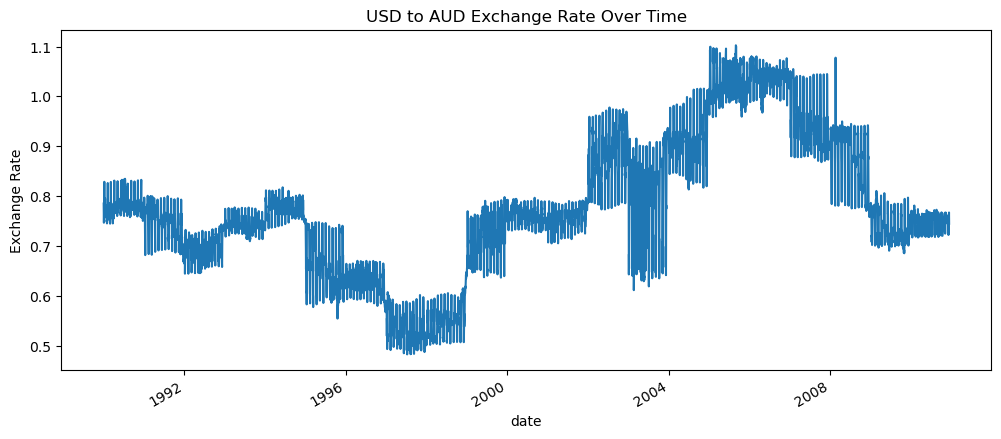

Ex_rate    0
dtype: int64


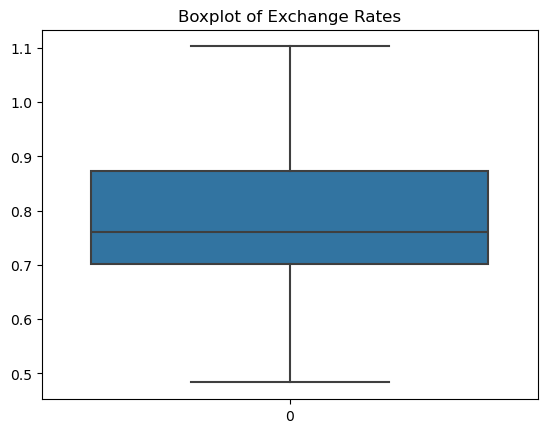

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("exchange_rate.csv" , parse_dates=["date"], index_col="date")

# Preview data
print(df.head())

# Plot time series
plt.figure(figsize=(12, 5))
df['Ex_rate'].plot(title="USD to AUD Exchange Rate Over Time")
plt.ylabel("Exchange Rate")
plt.show()

# Check for missing values
print(df.isnull().sum())

# Fill missing values if necessary
df['Ex_rate'] = df['Ex_rate'].interpolate(method='linear')

# Re-check for anomalies (basic outlier detection)
sns.boxplot(df['Ex_rate'])
plt.title("Boxplot of Exchange Rates")
plt.show()

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


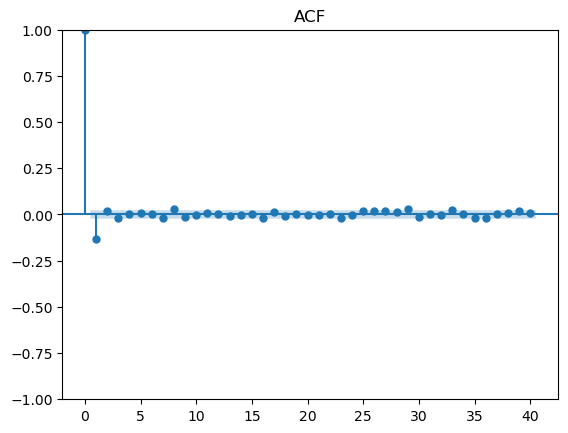

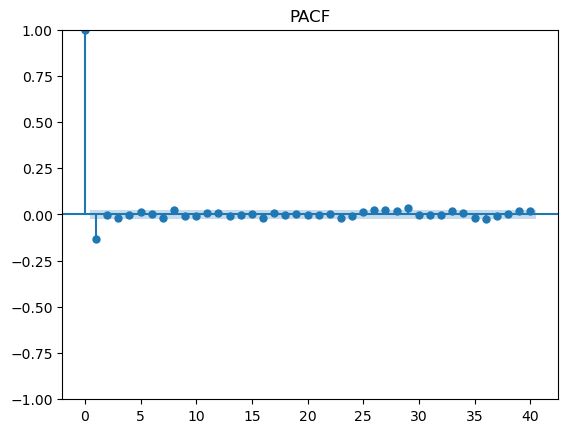

In [13]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If non-stationary, take differences
ts = df['Ex_rate']
ts_diff = ts.diff().dropna()

# ACF and PACF plots
plot_acf(ts_diff, lags=40)
plt.title("ACF")
plt.show()

plot_pacf(ts_diff, lags=40)
plt.title("PACF")
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Assume (p=1, d=1, q=1) for demonstration
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 14 May 2025   AIC                         -56102.322
Time:                        00:29:32   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

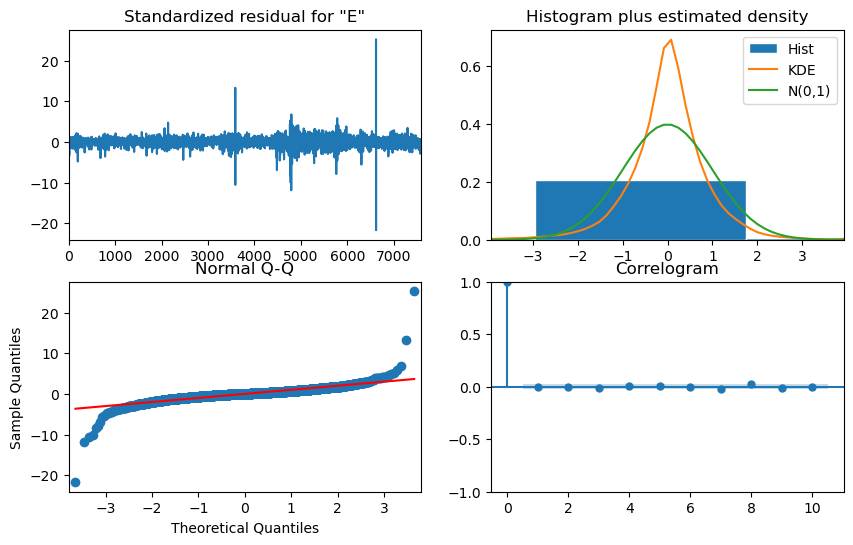

In [15]:
model_fit.plot_diagnostics(figsize=(10, 6))
plt.show()


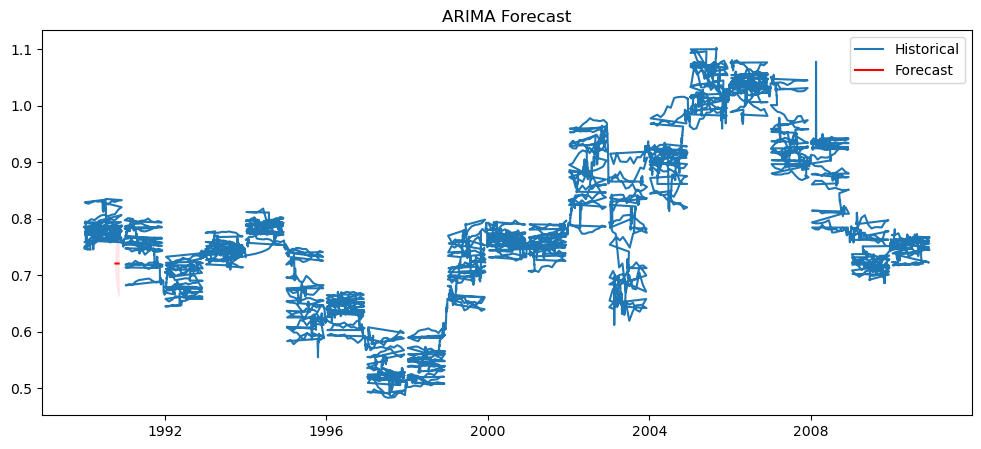

In [16]:
forecast = model_fit.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("ARIMA Forecast")
plt.legend()
plt.show()


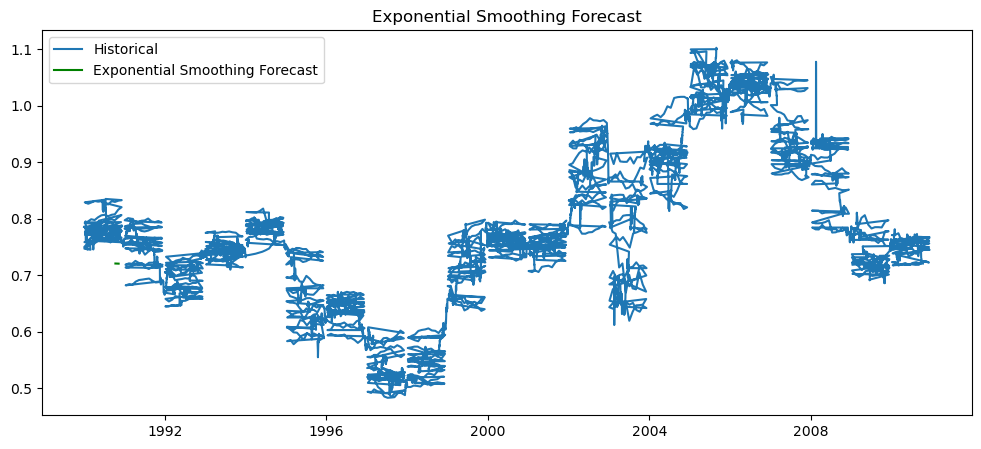

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
es_model = ExponentialSmoothing(ts, trend='add', seasonal=None)
es_fit = es_model.fit()

# Forecast
es_forecast = es_fit.forecast(30)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(es_forecast, label='Exponential Smoothing Forecast', color='green')
plt.title("Exponential Smoothing Forecast")
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Create test set
train = ts[:-30]
test = ts[-30:]

# ARIMA Forecast on test
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_pred = arima_model.forecast(steps=30)

# Holt-Winters Forecast
hw_model = ExponentialSmoothing(train, trend='add').fit()
hw_pred = hw_model.forecast(30)

# Evaluation Metrics
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate(test, arima_pred)
hw_mae, hw_rmse, hw_mape = evaluate(test, hw_pred)

print("ARIMA - MAE:", arima_mae, "RMSE:", arima_rmse, "MAPE:", arima_mape)
print("HWES  - MAE:", hw_mae, "RMSE:", hw_rmse, "MAPE:", hw_mape)


ARIMA - MAE: 0.013494600805702773 RMSE: 0.016632177912475444 MAPE: nan
HWES  - MAE: 0.013425279107668674 RMSE: 0.0164997815479368 MAPE: nan
